In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import schemdraw as SchemDraw
import schemdraw.elements as SchemDrawElement
import numpy as np
import ahkab
from ahkab import circuit, printing, time_functions
import pylab as plt

W: Locale appears not set! please export LANG="en_US.UTF-8" or equivalent, 
W: or ahkab's unicode support is broken.


In [4]:
mycir = ahkab.circuit.Circuit(title="Butterworth Example circuit")
voltage_step = time_functions.pulse(v1=0, v2=1, td=500e-9, tr=1e-12, pw=1, tf=1e-12, per=2)
#mycir.add_vsource("V1", n1="n1", n2=gnd, dc_value=5, ac_value=1, function=voltage_step)
#mycir.add_isource('Isource', 'nA', 'nD', dc_value=1)
#mycir.add_resistor('Rad', 'nA', 'nD', value=5)
#mycir.add_vsource('Vgnd', mycir.gnd, 'nC', dc_value=0)
#tp1 = mycir.create_node('tp1')
#out = mycir.create_node('out')
gnd = mycir.get_ground_node()
print(mycir)

* Butterworth Example circuit


In [5]:
import ahkab
from tempfile import NamedTemporaryFile

netlist = """
.title voltage divider
v1 vcc 0 type=vdc vdc=375 vac=1
r1 vcc tp1 30e6
r2 tp1 0 10e4
*r3 tp1 2 10e4
*r4 2 tp2 10e3
*r5 0 tp2 10e3

.dc tp1 0 2 0.05 
*vammeter vcc tp1 type=vdc vdc=0
"""

tp = NamedTemporaryFile(mode='w+', delete=False)
tp.write(netlist)
tp.close()

cir = ahkab.netlist_parser.parse_circuit(tp.name)[0]

op_analysis = ahkab.new_op(verbose=True)
ac_analysis = ahkab.new_ac(start=1e3, stop=1e5, points=100, verbose=True)
#dc_analysis = ahkab.new_dc(source=cir, start=1e3, stop=1e5, points=100, verbose=True)
tran_analysis = ahkab.new_tran(tstart=0, tstop=1.2e-3, tstep=1e-4, x0=None, verbose=True)
r = ahkab.run(cir, an_list=[op_analysis, ac_analysis, tran_analysis])

print(r.keys())
print(r['op'].keys())
print(r['ac'].keys())
print(r['tran'].keys())

Calculating guess: skipped. (linear circuit)
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)
Starting AC analysis: 
done.
dict_keys(['op', 'ac', 'tran'])
['VVCC', 'VTP1', 'I(V1)']
['f', 'Vvcc', 'Vtp1', 'I(V1)']
['T', 'VVCC', 'VTP1', 'I(V1)']


In [6]:
# op = r['op'].results
Vtp1_op = r['op']['VTP1'][0][0]
print(Vtp1_op)

Vtp1_ac = r['tran']['I(V1)'][0]
print(Vtp1_ac)

#Itp1_op = r['op']['I(VAMMETER)'][0][0]
#print(Itp1_op)

1.245847176079734
-1.2461971486924777e-05


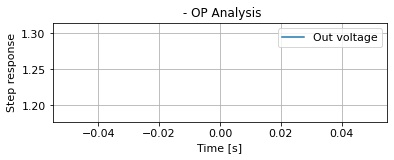

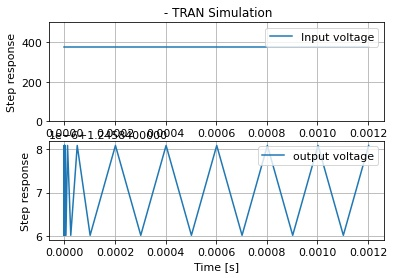

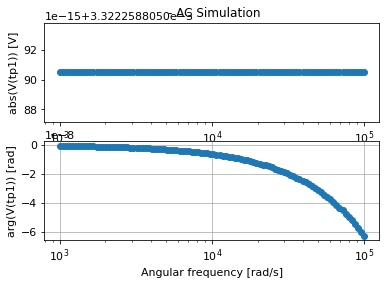

In [7]:
import pylab as plt
import numpy as np

fig = plt.figure()
plt.subplot(211)
plt.title(cir.title + " - OP Analysis")
plt.plot(r['op']['VTP1'], label="Out voltage")
plt.legend()
plt.grid(True)
plt.ylabel('Step response')
plt.xlabel('Time [s]')
plt.show()

fig = plt.figure()
plt.subplot(211)
plt.title(cir.title + " - TRAN Simulation")
plt.plot(r['tran']['T'], r['tran']['VVCC'], label="Input voltage")
plt.legend()
plt.grid(True)
plt.ylim([0,500])
plt.ylabel('Step response')
plt.xlabel('Time [s]')

plt.subplot(212)
plt.plot(r['tran']['T'], r['tran']['VTP1'], label="output voltage")
plt.legend()
plt.grid(True)
plt.ylabel('Step response')
plt.xlabel('Time [s]')
plt.show()
fig.savefig('tran_plot.png')

fig2 = plt.figure()
plt.subplot(211)
plt.semilogx(r['ac']['f'], np.abs(r['ac']['Vtp1']), 'o-')
plt.ylabel('abs(V(tp1)) [V]')
plt.title(cir.title + " - AC Simulation")
plt.subplot(212)
plt.grid(True)
plt.semilogx(r['ac']['f'], np.angle(r['ac']['Vtp1']), 'o-')
plt.xlabel('Angular frequency [rad/s]')
plt.ylabel('arg(V(tp1)) [rad]')
fig2.savefig('ac_plot.png')
plt.show()

In [11]:
import numpy as np
import scipy, scipy.interpolate

# Normalize the output to the low frequency value and convert to array
norm_out = np.abs(r['ac']['Vtp1'])/np.abs(r['ac']['Vtp1']).max()
# Convert to dB
norm_out_db = 20*np.log10(norm_out)
# Convert angular frequencies to Hz and convert matrix to array
frequencies = r['ac']['f']/2/np.pi
# call scipy to interpolate
norm_out_db_interpolated = scipy.interpolate.interp1d(frequencies, norm_out_db)

print ("Maximum attenuation in the pass band (0-%g Hz) is %g dB" % (2e3, -1.0*norm_out_db_interpolated(2e3)))
print ("Minimum attenuation in the stop band (%g Hz - Inf) is %g dB" % (6.5e3, -1.0*norm_out_db_interpolated(6.5e3)))

Maximum attenuation in the pass band (0-2000 Hz) is 8.37138e-14 dB
Minimum attenuation in the stop band (6500 Hz - Inf) is 8.87181e-14 dB
